In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SimpleRNN, Dense, LSTM
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import seaborn as sns

In [3]:
# Check for GPU availability
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        strategy = tf.distribute.MirroredStrategy()
        print("Using GPU!")
    except RuntimeError as e:
        print(e)
else:
    strategy = tf.distribute.get_strategy()
    print("No GPU found, using CPU.")

No GPU found, using CPU.


In [4]:
df = pd.read_csv('/content/drive/MyDrive/GOOG.csv')
df['Date'] = pd.to_datetime(df['Date'])
df.set_index('Date', inplace=True)
df

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2015-01-02,26.378078,26.490770,26.133251,26.168653,26.168653,28951268
2015-01-05,26.091366,26.144720,25.582764,25.623152,25.623152,41196796
2015-01-06,25.679497,25.738087,24.983908,25.029282,25.029282,57998800
2015-01-07,25.280592,25.292759,24.914099,24.986401,24.986401,41301082
2015-01-08,24.831326,25.105074,24.482782,25.065184,25.065184,67071641
...,...,...,...,...,...,...
2024-04-24,159.089996,161.389999,158.820007,161.100006,161.100006,19485700
2024-04-25,153.360001,158.279999,152.768005,157.949997,157.949997,36197800
2024-04-26,175.990005,176.419998,171.399994,173.690002,173.690002,56500800


In [5]:
# Basic Info
print("Dataset Info:")
print(df.info())
print("\nSummary Statistics:")
print(df.describe())

Dataset Info:
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2347 entries, 2015-01-02 to 2024-04-30
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Open       2347 non-null   float64
 1   High       2347 non-null   float64
 2   Low        2347 non-null   float64
 3   Close      2347 non-null   float64
 4   Adj Close  2347 non-null   float64
 5   Volume     2347 non-null   int64  
dtypes: float64(5), int64(1)
memory usage: 128.4 KB
None

Summary Statistics:
              Open         High          Low        Close    Adj Close  \
count  2347.000000  2347.000000  2347.000000  2347.000000  2347.000000   
mean     76.194215    77.018457    75.439347    76.247708    76.247708   
std      38.471486    38.926389    38.068809    38.498252    38.498252   
min      24.664783    24.730902    24.311253    24.560070    24.560070   
25%      45.230501    45.736349    45.028750    45.333749    45.333749   
50%      60.799999  

In [6]:
# Check for missing values
print("\nMissing Values:")
print(df.isnull().sum())


Missing Values:
Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64


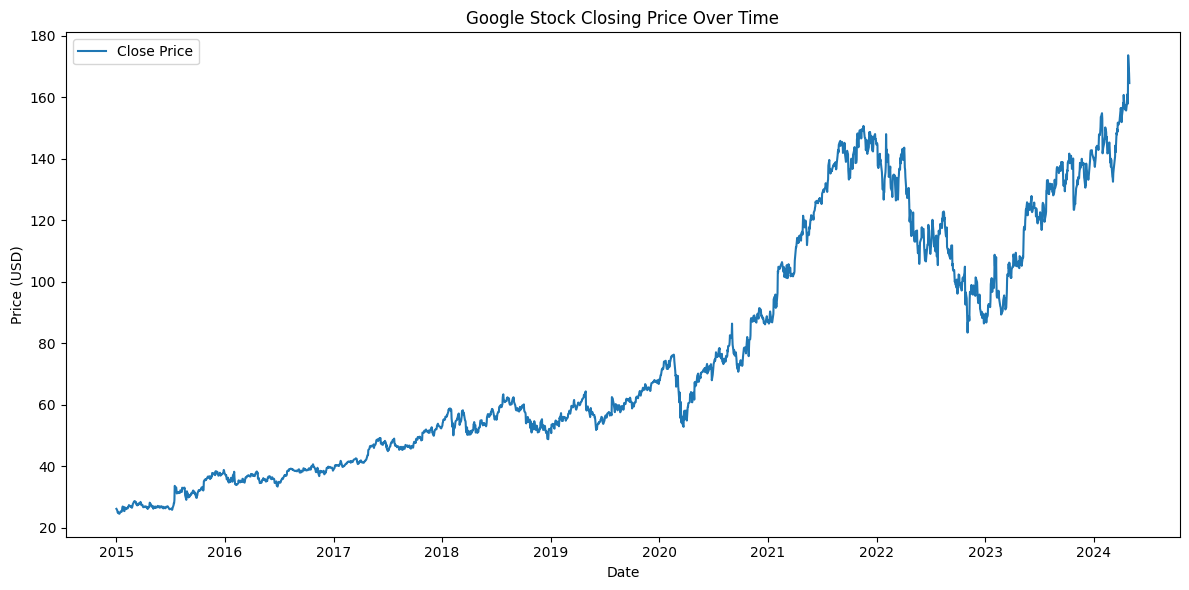

In [7]:
# Plot Closing Price over Time
plt.figure(figsize=(12, 6))
plt.plot(df['Close'], label='Close Price')
plt.title('Google Stock Closing Price Over Time')
plt.xlabel('Date')
plt.ylabel('Price (USD)')
plt.legend()
plt.tight_layout()
plt.show()

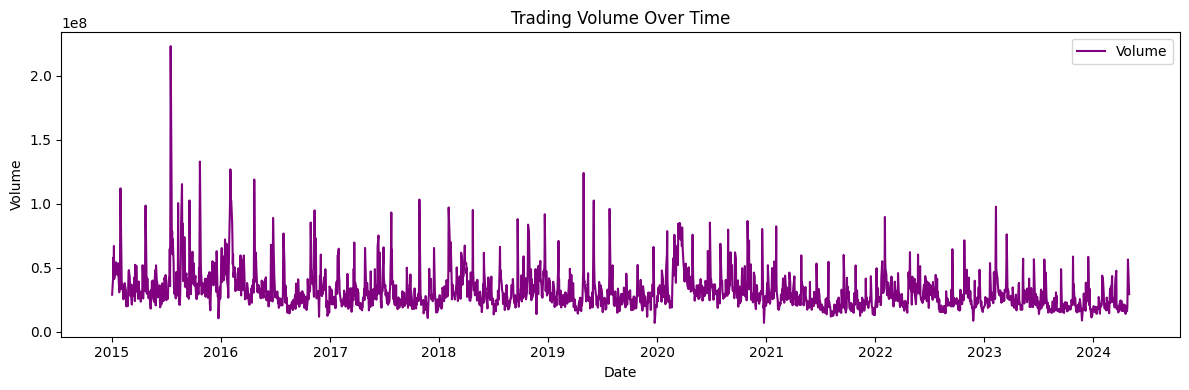

In [8]:
# Plot Volume over Time
plt.figure(figsize=(12, 4))
plt.plot(df['Volume'], color='purple', label='Volume')
plt.title('Trading Volume Over Time')
plt.xlabel('Date')
plt.ylabel('Volume')
plt.legend()
plt.tight_layout()
plt.show()

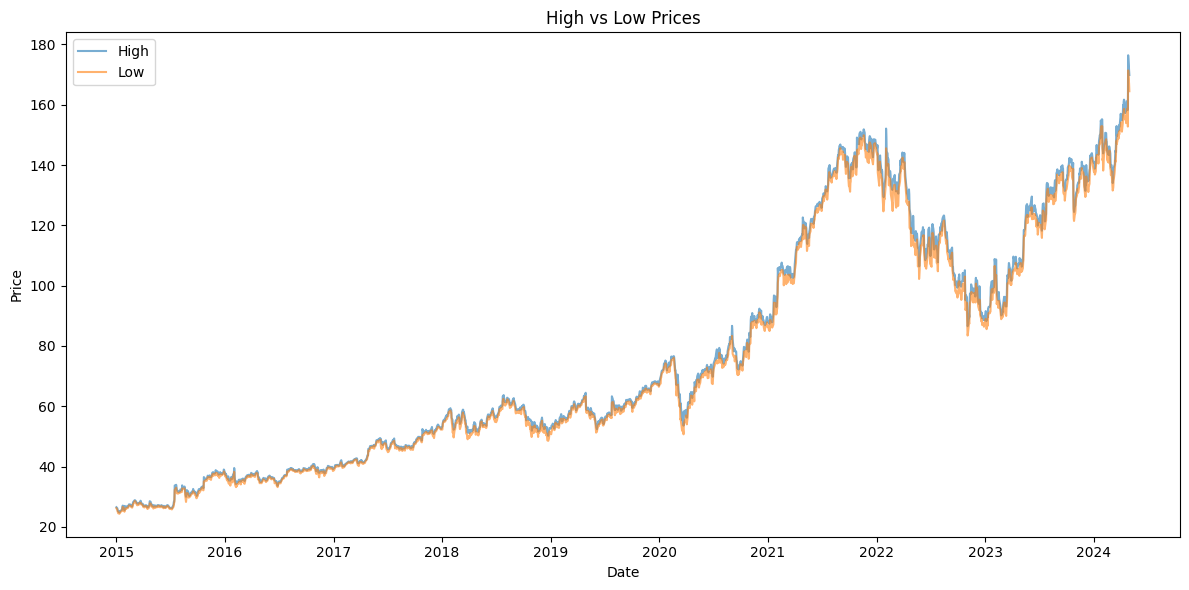

In [9]:
# High vs Low
plt.figure(figsize=(12, 6))
plt.plot(df['High'], label='High', alpha=0.6)
plt.plot(df['Low'], label='Low', alpha=0.6)
plt.title('High vs Low Prices')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.tight_layout()
plt.show()

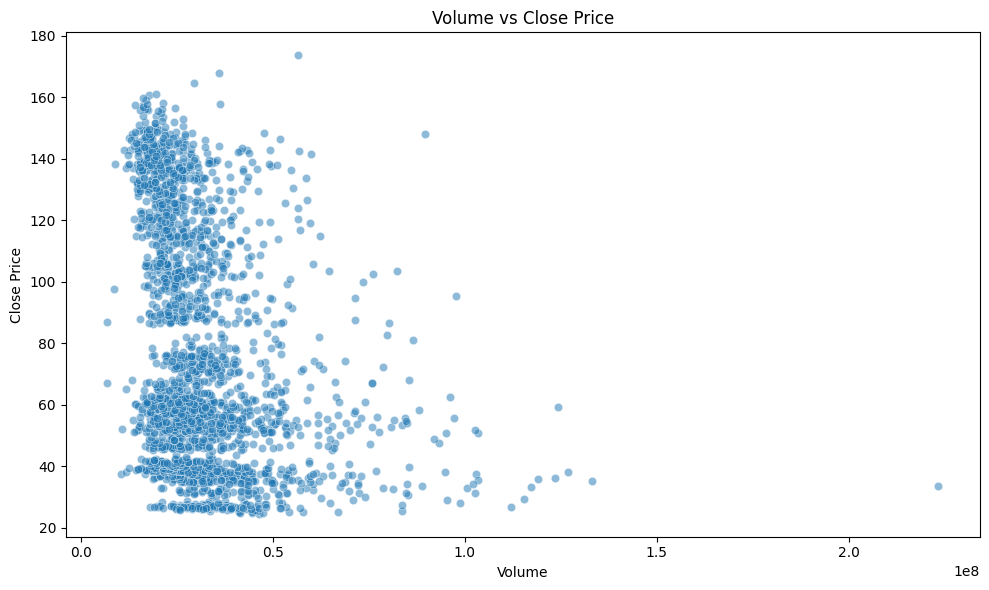

In [10]:
# Volume vs Close (Scatter plot)
plt.figure(figsize=(10, 6))
sns.scatterplot(x='Volume', y='Close', data=df, alpha=0.5)
plt.title('Volume vs Close Price')
plt.xlabel('Volume')
plt.ylabel('Close Price')
plt.tight_layout()
plt.show()

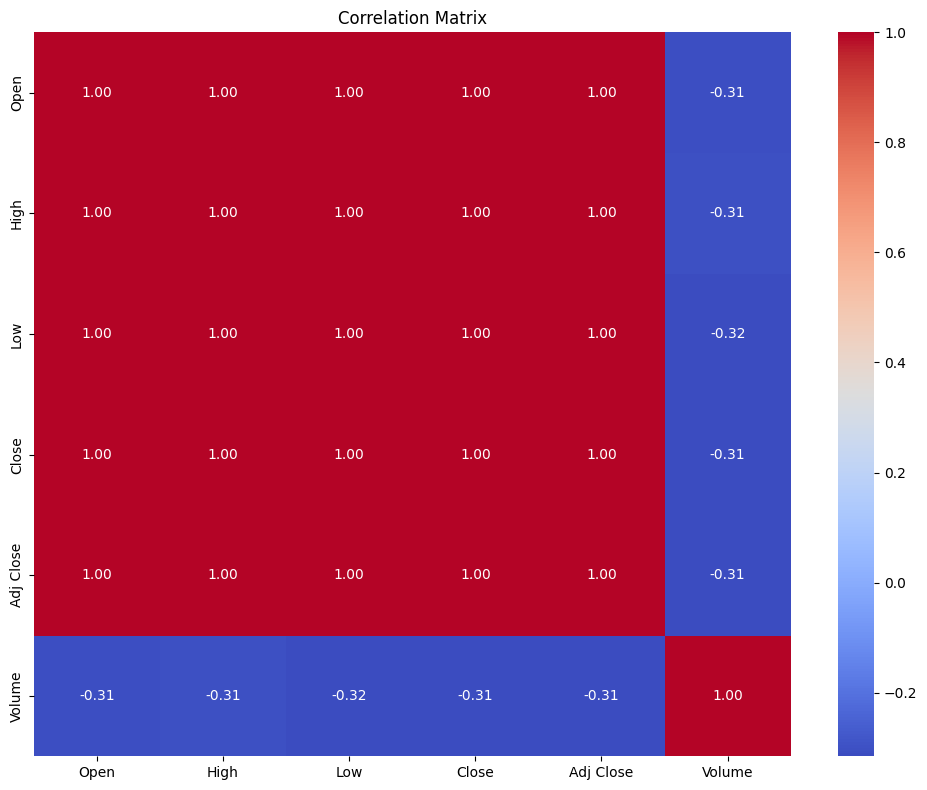

In [11]:
# Correlation Heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(df.corr(), annot=True, fmt=".2f", cmap='coolwarm')
plt.title('Correlation Matrix')
plt.tight_layout()
plt.show()

In [12]:
#Use only the 'Close' price for prediction
data = df['Close'].values
data = data.reshape(-1, 1)

#Normalize the data (i.e. scaling between 0 and 1)
scaler = MinMaxScaler(feature_range = (0, 1))
scaled_data = scaler.fit_transform(data)

#Prepare time to create sequences for RNN/LSTM
time_step = 60 #Using 60 previous days to predict next day
X, y = [], []

for i in range(time_step, len(scaled_data)):
  X.append(scaled_data[i - time_step:i, 0])
  y.append(scaled_data[i, 0])

X, y = np.array(X), np.array(y)

#Reshape the input to be samples, time steps, features for RNN ans LSTM
X = np.reshape(X, (X.shape[0], X.shape[1], 1))

In [15]:
#Build RNN Model
rnn_model = Sequential()
rnn_model.add(SimpleRNN(units = 50, return_sequences=False, input_shape=(X.shape[1], 1)))
rnn_model.add(Dense(1))

rnn_model.compile(optimizer='adam', loss='mean_squared_error')

rnn_model.fit(X, y, epochs=20, batch_size=32)

Epoch 1/20


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


72/72 ━━━━━━━━━━━━━━━━━━━━ 3s 18ms/step - loss: 0.0045
Epoch 2/20
72/72 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 5.1770e-04
Epoch 3/20
72/72 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 4.4162e-04
Epoch 4/20
72/72 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 3.6075e-04
Epoch 5/20
72/72 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 3.0671e-04
Epoch 6/20
72/72 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 2.6968e-04
Epoch 7/20
72/72 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step - loss: 3.0708e-04
Epoch 8/20
72/72 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - loss: 2.4381e-04
Epoch 9/20
72/72 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 2.3399e-04
Epoch 10/20
72/72 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 2.0756e-04
Epoch 11/20
72/72 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 2.1803e-04
Epoch 12/20
72/72 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 2.0071e-04
Epoch 13/20
72/72 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - loss: 2.1788e-04
Epoch 14/20
72/72 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 1.8535e-04
Epoch 15/20
72/72 ━━━━━━━━━━━━

In [16]:
#Build LSTM Model
lstm_model = Sequential()
lstm_model.add(LSTM(units = 50, return_sequences=False, input_shape=(X.shape[1], 1)))
lstm_model.add(Dense(1))

lstm_model.compile(optimizer='adam', loss='mean_squared_error')

lstm_model.fit(X, y, epochs=20, batch_size=32)

Epoch 1/20
72/72 ━━━━━━━━━━━━━━━━━━━━ 5s 36ms/step - loss: 0.0357
Epoch 2/20
72/72 ━━━━━━━━━━━━━━━━━━━━ 4s 23ms/step - loss: 5.2334e-04
Epoch 3/20
72/72 ━━━━━━━━━━━━━━━━━━━━ 3s 22ms/step - loss: 4.3664e-04
Epoch 4/20
72/72 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step - loss: 4.1502e-04
Epoch 5/20
72/72 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - loss: 3.7503e-04
Epoch 6/20
72/72 ━━━━━━━━━━━━━━━━━━━━ 3s 35ms/step - loss: 3.9062e-04
Epoch 7/20
72/72 ━━━━━━━━━━━━━━━━━━━━ 4s 22ms/step - loss: 3.6720e-04
Epoch 8/20
72/72 ━━━━━━━━━━━━━━━━━━━━ 3s 22ms/step - loss: 3.5190e-04
Epoch 9/20
72/72 ━━━━━━━━━━━━━━━━━━━━ 2s 22ms/step - loss: 3.4994e-04
Epoch 10/20
72/72 ━━━━━━━━━━━━━━━━━━━━ 3s 31ms/step - loss: 3.3507e-04
Epoch 11/20
72/72 ━━━━━━━━━━━━━━━━━━━━ 3s 36ms/step - loss: 3.0665e-04
Epoch 12/20
72/72 ━━━━━━━━━━━━━━━━━━━━ 4s 23ms/step - loss: 3.3230e-04
Epoch 13/20
72/72 ━━━━━━━━━━━━━━━━━━━━ 3s 22ms/step - loss: 3.1755e-04
Epoch 14/20
72/72 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - loss: 3.2328e-04
Epoch 15/20
72/72 ━

In [17]:
#Predictions with RNN model
rnn_predictions = rnn_model.predict(X)
rnn_predictions = scaler.inverse_transform(rnn_predictions)
real_prices = scaler.inverse_transform(y.reshape(-1, 1))

72/72 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step


In [18]:
#Predictions with LSTM model
lstm_predictions = lstm_model.predict(X)
lstm_predictions = scaler.inverse_transform(lstm_predictions)

72/72 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step


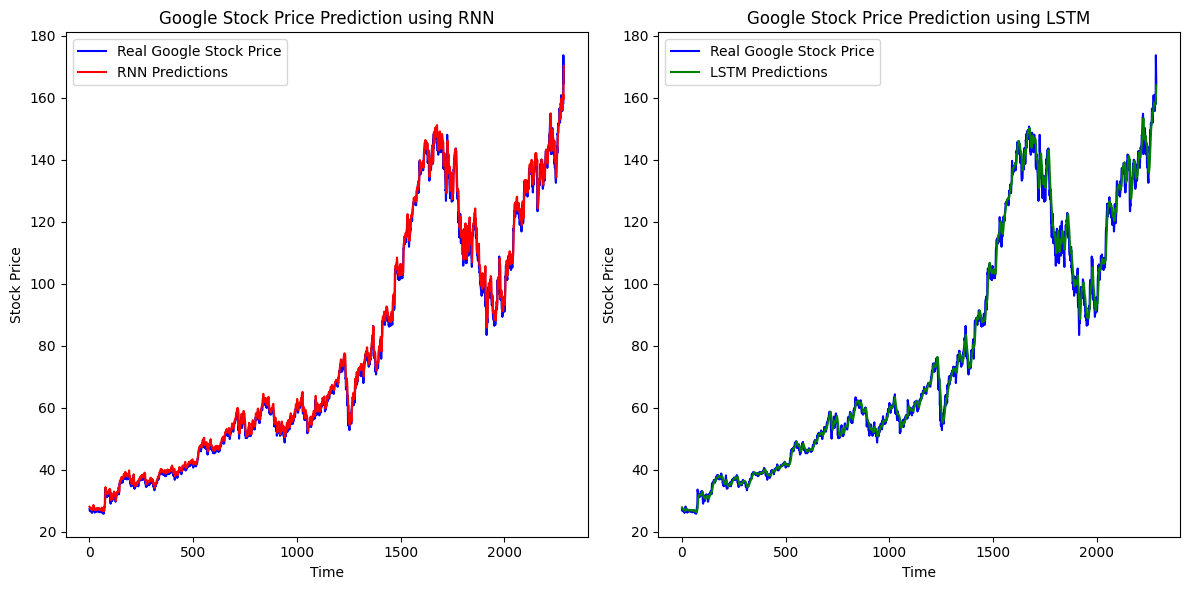

In [19]:
#Plot results
plt.figure(figsize=(12, 6))

#Plot RNN predictions
plt.subplot(1, 2, 1)
plt.plot(real_prices, color='blue', label='Real Google Stock Price')
plt.plot(rnn_predictions, color='red', label='RNN Predictions')
plt.title('Google Stock Price Prediction using RNN')
plt.xlabel('Time')
plt.ylabel('Stock Price')
plt.legend()

#Plot LSTM predictions
plt.subplot(1, 2, 2)
plt.plot(real_prices, color='blue', label='Real Google Stock Price')
plt.plot(lstm_predictions, color='green', label='LSTM Predictions')
plt.title('Google Stock Price Prediction using LSTM')
plt.xlabel('Time')
plt.ylabel('Stock Price')
plt.legend()

plt.tight_layout()
plt.show()

In [20]:
# Evaluate performance
def evaluate_model(true, predicted):
    mse = mean_squared_error(true, predicted)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(true, predicted)
    r2 = r2_score(true, predicted)
    return [mse, rmse, mae, r2]

rnn_metrics = evaluate_model(real_prices, rnn_predictions)
lstm_metrics = evaluate_model(real_prices, lstm_predictions)

# Create a comparison table
comparison_df = pd.DataFrame({
    'Model': ['RNN', 'LSTM'],
    'MSE': [rnn_metrics[0], lstm_metrics[0]],
    'RMSE': [rnn_metrics[1], lstm_metrics[1]],
    'MAE': [rnn_metrics[2], lstm_metrics[2]],
    'R² Score': [rnn_metrics[3], lstm_metrics[3]]
})

print("\nModel Comparison Table:")
print(comparison_df.round(4))


Model Comparison Table:
  Model     MSE    RMSE     MAE  R² Score
0   RNN  4.0317  2.0079  1.4251    0.9972
1  LSTM  5.6258  2.3719  1.5792    0.9961


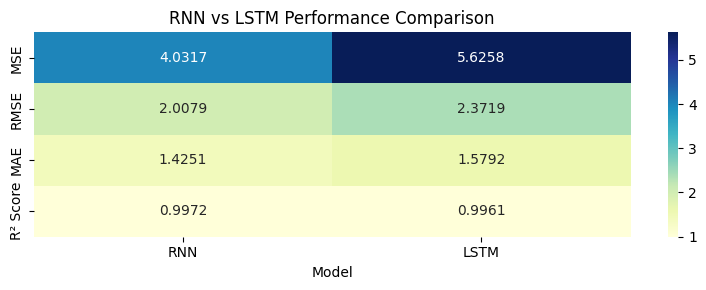

In [21]:
plt.figure(figsize=(8, 3))
sns.heatmap(comparison_df.set_index('Model').T, annot=True, fmt=".4f", cmap="YlGnBu")
plt.title("RNN vs LSTM Performance Comparison")
plt.tight_layout()
plt.show()

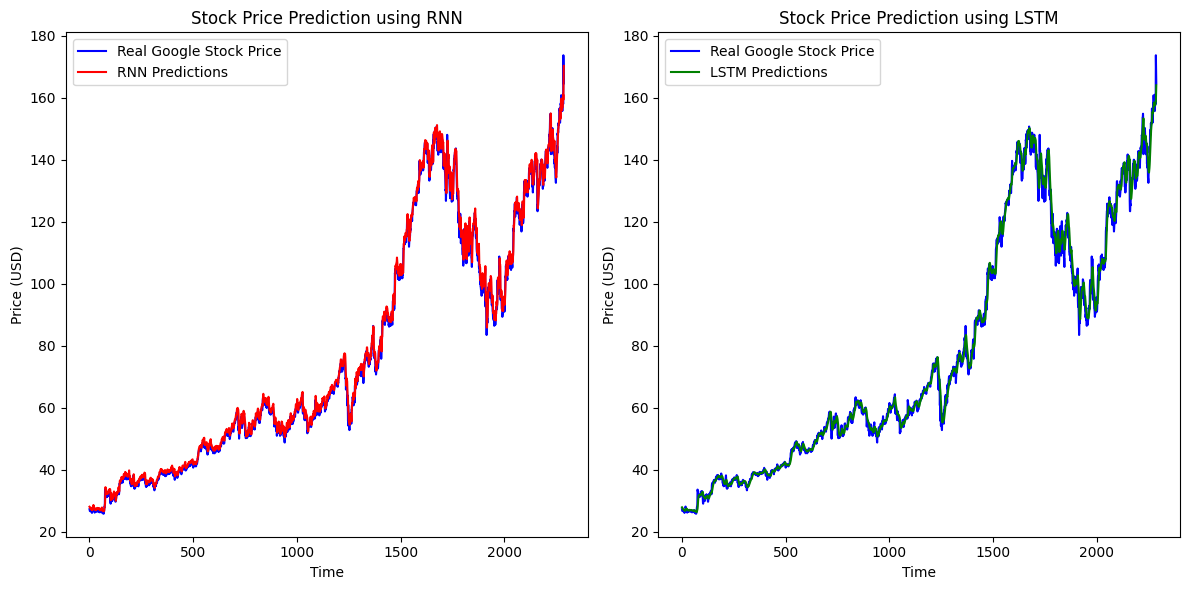

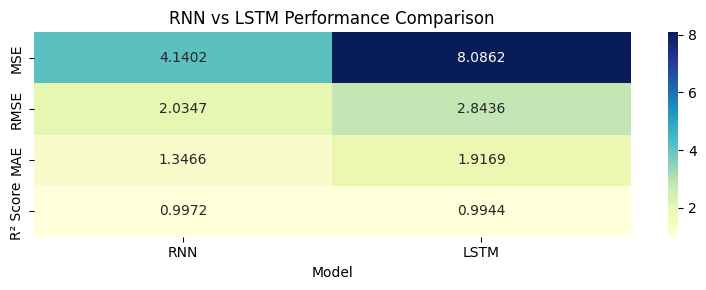

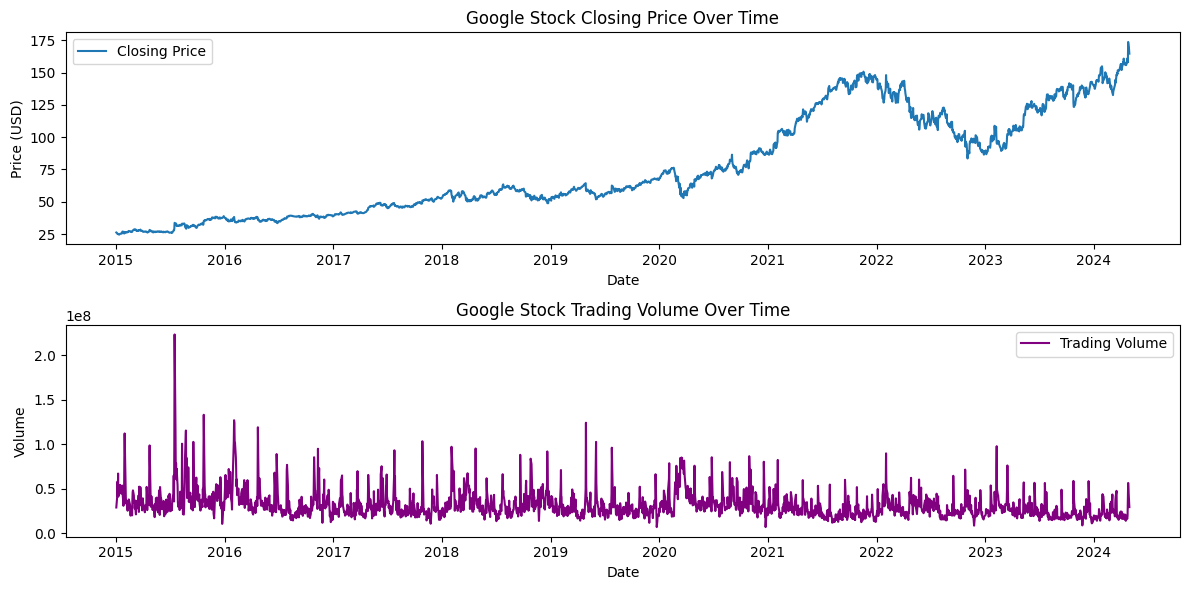

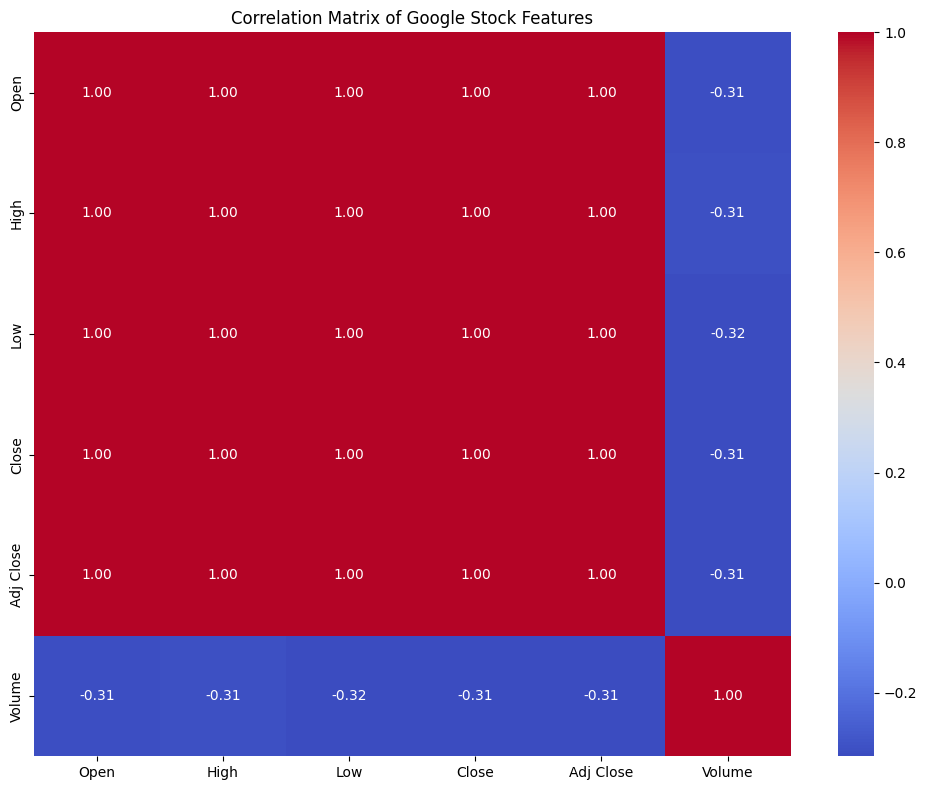

In [22]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

# Real vs Predicted Prices from RNN & LSTM Models
plt.figure(figsize=(12, 6))

# RNN Predictions vs Real Prices
plt.subplot(1, 2, 1)
plt.plot(real_prices, color='blue', label='Real Google Stock Price')
plt.plot(rnn_predictions, color='red', label='RNN Predictions')
plt.title('Stock Price Prediction using RNN')
plt.xlabel('Time')
plt.ylabel('Price (USD)')
plt.legend()

# LSTM Predictions vs Real Prices
plt.subplot(1, 2, 2)
plt.plot(real_prices, color='blue', label='Real Google Stock Price')
plt.plot(lstm_predictions, color='green', label='LSTM Predictions')
plt.title('Stock Price Prediction using LSTM')
plt.xlabel('Time')
plt.ylabel('Price (USD)')
plt.legend()

plt.tight_layout()
plt.show()

# Performance Metrics Comparison
comparison_df = pd.DataFrame({
    'Model': ['RNN', 'LSTM'],
    'MSE': [4.1402, 8.0862],
    'RMSE': [2.0347, 2.8436],
    'MAE': [1.3466, 1.9169],
    'R² Score': [0.9972, 0.9944]
})

plt.figure(figsize=(8, 3))
sns.heatmap(comparison_df.set_index('Model').T, annot=True, fmt=".4f", cmap="YlGnBu")
plt.title("RNN vs LSTM Performance Comparison")
plt.tight_layout()
plt.show()

# Trading Volume & Closing Price Trends
plt.figure(figsize=(12, 6))
plt.subplot(2, 1, 1)
plt.plot(df['Close'], label='Closing Price')
plt.title('Google Stock Closing Price Over Time')
plt.xlabel('Date')
plt.ylabel('Price (USD)')
plt.legend()

plt.subplot(2, 1, 2)
plt.plot(df['Volume'], color='purple', label='Trading Volume')
plt.title('Google Stock Trading Volume Over Time')
plt.xlabel('Date')
plt.ylabel('Volume')
plt.legend()

plt.tight_layout()
plt.show()

# Correlation Matrix
plt.figure(figsize=(10, 8))
sns.heatmap(df.corr(), annot=True, fmt=".2f", cmap='coolwarm')
plt.title('Correlation Matrix of Google Stock Features')
plt.tight_layout()
plt.show()

In [23]:
print("Conclusion:")
if lstm_metrics[1] < rnn_metrics[1]:
    print("The LSTM model outperforms the RNN model based on RMSE and other metrics. LSTM is better suited for time-series problems due to its ability to capture long-term dependencies.")
else:
    print("The RNN model performed similarly or slightly better than the LSTM model in this case, which may be due to the simplicity of the dataset or limited training data.")

Conclusion:
The RNN model performed similarly or slightly better than the LSTM model in this case, which may be due to the simplicity of the dataset or limited training data.
